Text analysis of the net neutrality tweets was performed in several ways. The text data was imported and processed for analysis including tokenizing and vectorizing the tweets.  Kmeans clustering was used to evaluate what clusters exist in the text.  Topic modeling was performed using two different algorithms, followed by sentiment analysis.

* [Import of packages and data](#section1)
* [Clean, Tokenize and Vectorize Text Data for Analysis](#section2)
* [Clustering - What are the top text clusters?](#section3)
* [Topic Modeling - Two Algorithmic Approaches](#section4)
* [Sentiment Analysis](#section5)

<a id='section1'></a>

### Import of packages and data

#### Import needed packages

In [1]:
import json
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import re
import string
import nltk
from collections import Counter
stopwords = nltk.corpus.stopwords.words('english')
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import TweetTokenizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from gensim import corpora, models
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from collections import OrderedDict
from gensim import corpora, models, similarities

#### Import and prepare tweet data

In [2]:
tweet_files = ['#NetNeutrality/#NetNeutrality_2018-01-22.json', 'net/net_2018-01-22.json', '#NetNeutrality/#NetNeutrality_2018-01-23.json', 'net/net_2018-01-23.json', '#NetNeutrality/#NetNeutrality_2018-01-24.json', 'net/net_2018-01-24.json', '#NetNeutrality/#NetNeutrality_2018-01-25.json', 'net/net_2018-01-25.json', '#NetNeutrality/#NetNeutrality_2018-01-26.json', 'net/net_2018-01-26.json', '#NetNeutrality/#NetNeutrality_2018-01-27.json', 'net/net_2018-01-27.json', '#NetNeutrality/#NetNeutrality_2018-01-28.json', 'net/net_2018-01-28.json', '#NetNeutrality/#NetNeutrality_2018-01-29.json', 'net/net_2018-01-29.json', '#NetNeutrality/#NetNeutrality_2018-01-30.json', 'net/net_2018-01-30.json', '#NetNeutrality/#NetNeutrality_2018-01-31.json', 'net/net_2018-01-31.json', '#NetNeutrality/#NetNeutrality_2018-02-01.json', 'net/net_2018-02-01.json', '#NetNeutrality/#NetNeutrality_2018-02-02.json', 'net/net_2018-02-02.json', '#NetNeutrality/#NetNeutrality_2018-02-03.json', 'net/net_2018-02-03.json', '#NetNeutrality/#NetNeutrality_2018-02-04.json', 'net/net_2018-02-04.json', '#NetNeutrality/#NetNeutrality_2018-02-05.json', 'net/net_2018-02-05.json', '#NetNeutrality/#NetNeutrality_2018-02-06.json', 'net/net_2018-02-06.json', '#NetNeutrality/#NetNeutrality_2018-02-07.json', 'net/net_2018-02-07.json', '#NetNeutrality/#NetNeutrality_2018-02-08.json', 'net/net_2018-02-08.json', '#NetNeutrality/#NetNeutrality_2018-02-09.json', 'net/net_2018-02-09.json', '#NetNeutrality/#NetNeutrality_2018-02-10.json', 'net/net_2018-02-10.json', '#NetNeutrality/#NetNeutrality_2018-02-11.json', 'net/net_2018-02-11.json', '#NetNeutrality/#NetNeutrality_2018-02-12.json', 'net/net_2018-02-12.json', '#NetNeutrality/#NetNeutrality_2018-02-13.json', 'net/net_2018-02-13.json', '#NetNeutrality/#NetNeutrality_2018-02-14.json', 'net/net_2018-02-14.json', '#NetNeutrality/#NetNeutrality_2018-02-15.json', 'net/net_2018-02-15.json', '#NetNeutrality/#NetNeutrality_2018-02-16.json', 'net/net_2018-02-16.json', '#NetNeutrality/#NetNeutrality_2018-02-16_to_2018-02-17.json', '#NetNeutrality/#NetNeutrality_2018-02-17.json', 'net/net_2018-02-17.json', '#NetNeutrality/#NetNeutrality_2018-02-18.json', 'net/net_2018-02-18.json', '#NetNeutrality/#NetNeutrality_2018-02-19.json', 'net/net_2018-02-19.json', '#NetNeutrality/#NetNeutrality_2018-02-20.json', 'net/net_2018-02-20.json', '#NetNeutrality/#NetNeutrality_2018-02-21.json', 'net/net_2018-02-21.json', '#NetNeutrality/#NetNeutrality_2018-02-22.json', 'net/net_2018-02-22.json', '#NetNeutrality/#NetNeutrality_2018-02-23.json', 'net/net_2018-02-23.json', '#NetNeutrality/#NetNeutrality_2018-02-24.json', 'net/net_2018-02-24.json', '#NetNeutrality/#NetNeutrality_2018-02-25.json', 'net/net_2018-02-25.json', '#NetNeutrality/#NetNeutrality_2018-02-26.json', 'net/net_2018-02-26.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

In [3]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
    df['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets))                
    df['tweet_date'] = list(map(lambda tweet: tweet['created_at'], tweets))
    df['user_id'] = list(map(lambda tweet: tweet['user']['id'], tweets))                      
    df['screen_name'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets))                
    df['name'] = list(map(lambda tweet: tweet['user']['name'], tweets))               
    df['description'] = list(map(lambda tweet: tweet['user']['description'], tweets))                
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
    df['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets))
    df['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets))               
    df['user_location'] = list(map(lambda tweet: tweet['user']['location'] 
                        if tweet['place'] != None else '', tweets))
    df['tweet_location'] = list(map(lambda tweet: tweet['place']['full_name'] 
                        if tweet['place'] != None else '', tweets))
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    return df

In [4]:
df = populate_tweet_df(tweets)

In [5]:
df = df.drop_duplicates(["tweet_id"])

In [6]:
def parse_location(string):
    if (string.split(',')[-1] == ' USA'):
        return string.split(',')[0]
    else:
        return string.split(', ')[-1]
df['state'] = df['tweet_location'].map(parse_location)

In [7]:
statedict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [8]:
for key, value in statedict.items():
    df['state'] = df['state'].replace(key, value)

In [51]:
otherlocdict = {
        'Alberta': 'Outside US',
        'Algarrobos': 'Outside US',
        'Amherst Regional Middle School': 'Massachusetts',
        'Apulia': 'Outside US',
        'Argentina': 'Outside US',
        'Atlanta': 'Georgia',
        'Austria': 'Outside US',
        'Bahamas': 'Outside US',
        'Baja California': 'Outside US',
        'Bangladesh': 'Outside US',
        'Barbados': 'Outside US',
        'Barcelona': 'Outside US',
        'Bavaria': 'Outside US',
        'Bayamón': 'Outside US',
        'Belgium': 'Outside US',
        'België': 'Outside US',
        'Berlin': 'Outside US',
        'Brasil': 'Outside US',
        'Brazil': 'Outside US',
        'British Columbia': 'Outside US',
        'California State Capitol Building': 'California',
        'Campania': 'Outside US',
        'Canada': 'Outside US',
        'Carolina Bay': 'North Carolina',
        'Caveat': 'Outside US',
        'Changwat Chon Buri': 'Outside US',
        'Channel Islands Harbor Green Navigation Light': 'California',
        'Chicago': 'Illinois',
        'Chihuahua': 'Outside US',
        'Chile': 'Outside US',
        'Colombia': 'Outside US',
        'Costa Rica': 'Outside US',
        'Cuba': 'Outside US',
        'Czech Republic': 'Outside US',
        'Davao Region': 'Outside US',
        'Denmark': 'Outside US',
        'Deutschland': 'Outside US',
        'Distrito Federal': 'Outside US',
        'Dovetail Brewing': 'Illinois',
        'Duluth MN-Superior WI': 'Minnesota',
        'East': 'Outside US',
        'Ecuador': 'Outside US',
        'El Salvador': 'Outside US',
        'England': 'Outside US',
        'Espanya': 'Outside US',
        'España': 'Outside US',
        'Finland': 'Outside US',
        'France': 'Outside US',
        'Frankfurt Airport': 'Outside US',
        'Germany': 'Outside US',
        'Greece': 'Outside US',
        'Hato Rey Sur': 'Puerto Rico',
        'Honduras': 'Outside US',
        'Hong Kong': 'Outside US',
        'Hungary': 'Outside US',
        'Iceland': 'Outside US',
        'India': 'Outside US',
        'Indonesia': 'Outside US',
        'Ireland': 'Outside US',
        'Isle of Man': 'Outside US',
        'Israel': 'Outside US',
        'Jamaica': 'Outside US',
        'Kenya': 'Outside US',
        'Kingdom of Saudi Arabia': 'Outside US',
        'Kuala Lumpur Federal Territory': 'Outside US',
        'Lazio': 'Outside US',
        'Liguria': 'Outside US',
        'Lombardia': 'Outside US',
        'Lombardy': 'Outside US',
        'London': 'Outside US',
        'Los Angeles': 'California',
        'Luxembourg': 'Outside US',
        'Maldives': 'Outside US',
        'Manitoba': 'Outside US',
        'Marche': 'Outside US',
        'Massachusetts State House': 'Massachusetts',
        'México': 'Outside US',
        'Morocco': 'Outside US',
        'Mordor': 'Outside US',
        'München': 'Outside US',
        'National Capital Region': 'District of Columbia',
        'Nebraska State Capitol Building': 'Nebraska',
        'Nederland': 'Colorado',
        'Nepal': 'Outside US',
        'New South Wales': 'Outside US',
        'New Zealand': 'Outside US',
        'Newfoundland and Labrador': 'Outside US',
        'Newseum - Knight Conference Center': 'District of Columbia',
        'Nigeria': 'Outside US',
        'Norge': 'Outside US',
        'Northern Essex Community College': 'Outside US',
        'Northern Ireland': 'Outside US',
        'Nova Scotia': 'Outside US',
        'Nuevo León': 'Outside US',
        'Nürnberg': 'Outside US',
        'Odessa High School': 'Texas',
        'Ontario': 'Outside US',
        'Oregon State Capitol Building': 'Oregon',
        'Osaka': 'Outside US',
        'Pakistan': 'Outside US',
        'Paradise': 'Outside US',
        "People's Republic of China": 'Outside US',
        'Perlis': 'Louisiana',
        'Piedmont': 'Outside US',
        'Playa': 'Outside US',
        'Poland': 'Outside US',
        'Portland': 'Oregon',
        'Portugal': 'Outside US',
        'Queens': 'New York',
        'Queensland': 'Outside US',
        'Quintana Roo': 'Outside US',
        'Québec': 'Outside US',
        'Republic of Korea': 'Outside US',
        'Republic of Mauritius': 'Outside US',
        'Rhode Island State House': 'Rhode Island',
        'Rochester': 'New York',
        'Romania': 'Outside US',
        'Russia': 'Outside US',
        'Sacramento State': 'California',
        'Sarawak': 'Outside US',
        'Saskatchewan': 'Outside US',
        'Schleswig-Holstein': 'Outside US',
        'Schweiz': 'Outside US',
        'Scotland': 'Outside US',
        'Seattle': 'Washington',
        'Selangor': 'Outside US',
        'Singapore': 'Outside US',
        'South Africa': 'Outside US',
        'Spain': 'Outside US',
        'Sri Lanka': 'Outside US',
        'Suomi': 'Outside US',
        'Sverige': 'Outside US',
        'Sweden': 'Outside US',
        'Switzerland': 'Outside US',
        'Taiwan': 'Outside US',
        'Tasmania': 'Outside US',
        'Thailand': 'Outside US',
        'The Netherlands': 'Outside US',
        'The Urban Hive': 'California',
        'Tokyo': 'Outside US',
        'Tokyo 23 ward': 'Outside US',
        'Toronto': 'Outside US',
        'Trinidad and Tobago': 'Outside US',
        'United Arab Emirates': 'Outside US',
        'United Kingdom': 'Outside US',
        'University of Glasgow': 'Outside US',
        'University of La Verne': 'California',
        'VCU Pocahontas Building': 'Virginia',
        'Veneto': 'Outside US',
        'Victoria': 'Outside US',
        'Vintage Marina C19': 'California',
        'Wales': 'Outside US',
        'Washington D.C.': 'District of Columbia',
        'Yamaguchi': 'Outside US'
}

In [52]:
for key, value in otherlocdict.items():
    df['state'] = df['state'].replace(key, value)

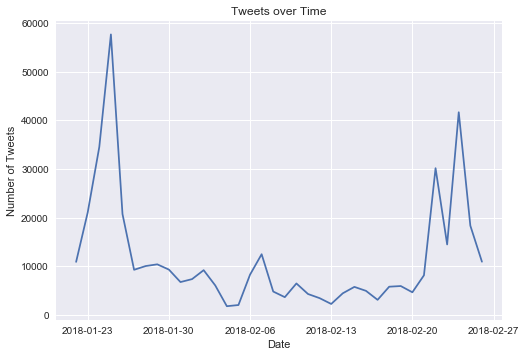

In [12]:
# Convert tweet date to a datetime object
df['tweet_date'] = pd.to_datetime(df['tweet_date'],  errors='raise')
df.groupby(df['tweet_date'].dt.date).size().plot()
plt.title('Tweets over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [13]:
df.shape

(421316, 14)

<a id='section2'></a>

### Clean, Tokenize and Vectorize Text Data for Analysis

In [14]:
tweettext = df.text.tolist()

In [114]:
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))

def clean_tweet(tweet):
    # Remove RT (retweet signal)
    tweet = re.sub('RT @', '@', tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*','', tweet)
    # Remove URLs
    tweet = re.sub(r'https?:\/\/.*\/\w*','', tweet)
    # Remove puncutation
    tweet = re.sub(r'[' + string.punctuation + ']+', ' ', tweet)
    # Remove stopwords
    tweet = re.sub(RE_stopwords, ' ', tweet)
    # Tokenize text
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    # Remove stopwords and single characters
    tokens = [i.lower() for i in tokens if i not in stopwords and len(i) > 1]
    return tokens

In [115]:
cleaned_tweets = []
for tweet in tweettext:
    cleaned_tweets.append(clean_tweet(tweet))

In [116]:
len(cleaned_tweets), len(df)

(421316, 421316)

In [117]:
df['cleaned_text'] = cleaned_tweets

In [118]:
df.head()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt,state,cleaned_text,cluster_id,cluster_id2,sentiment
170202,957667089581568000,2018-01-28 17:30:01,820187383,Britpoptarts,🔹🔷Britpoptarts🔷🔹,"❝Ah, it stinks, it sucks; it's anthropological...",RT @CriticalDragon1: The folks at @BurgerKing ...,13,0,,,NaN,NaN,,"[matthewbender, netneutrality, how, going, loo...",4,0,1.0
41866,956228970529243136,2018-01-24 18:15:27,34497954,shafithinks,shafi saxena,Wonders. Wanders. Lingers on occasion.,@BurgerKing This delicious take on #NetNeutral...,1,24,,,NaN,NaN,,"[deadpoolresists, montana, becomes, first, sta...",4,0,1.0
89858,956646912916062214,2018-01-25 21:56:12,379170406,k_morton9,Kyle Morton,"raleigh kid. fordham alum. analytics, podcast,...",RT @bluthquotes: It’s a wonderful restaurant! ...,71,0,,,NaN,NaN,,"[fightfortheftr, we, one, vote, away, winning,...",4,0,1.0
81459,956410853338820609,2018-01-25 06:18:11,256169510,donmartin76,Martin Danielsson,"Father, Husband, Developer, Architect and Gene...",This is awesome: @BurgerKing explains #NetNeut...,0,0,,,NaN,NaN,,"[freepress, don, fooled, your, activism, suppo...",4,0,1.0
327921,966161257702346752,2018-02-21 04:02:48,42681826,AndrewRostan,Andrew Rostan,"I wrote An Elegy for Amelia Johnson, one of US...",Excellent thread on defending #NetNeutrality h...,0,0,,,NaN,NaN,,"[freepress, we, suing, fcc, save, netneutralit...",4,0,1.0


In [119]:
cleaned_texts = df.cleaned_text.apply(lambda x: ' '.join(x))

In [120]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1, 2))  
transformed = vectorizer.fit_transform(cleaned_texts.values)
features = vectorizer.get_feature_names()

In [121]:
transformed.shape

(421316, 430105)

In [122]:
vectorizer2 = TfidfVectorizer(use_idf=True, ngram_range=(3,4))  
transformed2 = vectorizer2.fit_transform(cleaned_texts.values)
features2 = vectorizer2.get_feature_names()

In [123]:
transformed2.shape

(421316, 943102)

##### Clean user description text also

In [206]:
descr_text = df.description.tolist()
cleaned_description = []
for tweet in descr_text:
    cleaned_description.append(clean_tweet(tweet))

In [210]:
df['cleaned_description'] = cleaned_description
cleaned_description = df.cleaned_description.apply(lambda x: ' '.join(x))

In [211]:
vectorizer3 = TfidfVectorizer(use_idf=True, ngram_range=(1, 2))  
transformed3 = vectorizer3.fit_transform(cleaned_description.values)
features3 = vectorizer3.get_feature_names()

<a id='section3'></a>

### Clustering - What are the top text clusters?

Kmeans clustering was used to identify clusters in the transformed vectorized text data with an n-gram of 1-2.

In [124]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, n_jobs=1)
kmeans.fit(transformed)
clusters = kmeans.labels_.tolist()
df['cluster_id'] = clusters

df.cluster_id.value_counts()

4    351834
0     24301
3     20524
1     12602
2     12055
Name: cluster_id, dtype: int64

In [125]:
# sort cluster centers by proximity to centroid
centroids_order = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print('\n\nTop terms in cluster {}:\n'.format(i))
    for idx in centroids_order[i, :10]:
        print('\t{}'.format(features[idx]))



Top terms in cluster 0:

	we whopper
	explain repeal
	how would
	would explain
	burgerking how
	watch video
	whopper watch
	neutrality we
	watch
	how


Top terms in cluster 1:

	pass
	need
	we need
	resolution
	we
	permanent
	senate
	law
	senate resolution
	resolution block


Top terms in cluster 2:

	forget close
	cant forget
	lessened last
	months cant
	lessened
	coverage lessened
	netneutrality coverage
	last couple
	though netneutrality
	couple months


Top terms in cluster 3:

	nra
	nra position
	mattyglesias why
	position net
	mattyglesias
	why nra
	position
	neutrality regulations
	regulations
	why


Top terms in cluster 4:

	net
	neutrality
	net neutrality
	netneutrality
	fcc
	the
	internet
	state
	montana
	repeal


The clusters do appear to focus on slightly different issues around net neutrality.  Cluster 0 is about the Burger King commercial, Cluster 1 the need for permanent resolution to the net neutrality repeal via the Senate, Cluster 2 the risk of decreased coverage without net neutrality, Cluster 3 the NRA and government regulation, and Cluster 4 generally net neutrality and the Montana executive order protecting it.

#### Repeat clustering with different n-gram range in vectorizer

Clustering was repeated with an n-gram range of 3-4.

In [126]:
n_clusters = 5

kmeans2 = KMeans(n_clusters=n_clusters, n_jobs=1)
kmeans2.fit(transformed2)
clusters2 = kmeans2.labels_.tolist()
df['cluster_id2'] = clusters2

df.cluster_id2.value_counts()

0    358061
4     24285
3     21883
1     10694
2      6393
Name: cluster_id2, dtype: int64

In [127]:
# sort cluster centers by proximity to centroid
centroids_order2 = kmeans2.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print('\n\nTop terms in cluster {}:\n'.format(i))
    for idx in centroids_order2[i, :10]:
        print('\t{}'.format(features2[idx]))



Top terms in cluster 0:

	signed executive order
	net neutrality rules
	net neutrality repeal
	executive order mandating
	signed executive order mandating
	internet service providers
	cared net neutrality
	becomes first state
	montana becomes first
	montana becomes first state


Top terms in cluster 1:

	touch overwhelming majority americans
	touch overwhelming majority
	could touch overwhelming
	could touch overwhelming majority
	overwhelming majority americans turns
	nra could touch overwhelming
	majority americans turns
	nra could touch
	thought nra could
	thought nra could touch


Top terms in cluster 2:

	the government take away
	the government take
	government take away
	government take away net
	jackedyotweets the government
	jackedyotweets the government take
	away net neutrality guns
	net neutrality guns
	take away net neutrality
	take away net


Top terms in cluster 3:

	why nra position net
	why nra position
	mattyglesias why nra
	mattyglesias why nra position
	position n

With the larger n-grams, the clusters remain similar, if shifted in order.  Cluster 0 is about Montana being the first state to sign an executive order protecting net neutrality, Cluster 1 the NRA and the issue affecting the majority of Americans, Cluster 2 the government taking away rights/guns, Cluster 3 lessened coverage and regulations as well as the NRA's position on the topic (recently highlighted when the NRA gifted a rifle to the FCC chair as thanks for repealing net neutrality), and Cluster 4 the Burker King commercial.

With a larger n-gram range the clusters are easier to understand the topics.

##### Perform same cluster analysis on tweet user descriptions

In [216]:
n_clusters = 5

kmeans3 = KMeans(n_clusters=n_clusters, n_jobs=1)
kmeans3.fit(transformed3)
clusters3 = kmeans3.labels_.tolist()
df['cluster_id3'] = clusters3

df.cluster_id3.value_counts()

2    387886
1     22673
3      6526
0      2236
4      1995
Name: cluster_id3, dtype: int64

In [217]:
# sort cluster centers by proximity to centroid
centroids_order3 = kmeans3.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print('\n\nTop terms in cluster {}:\n'.format(i))
    for idx in centroids_order[i, :10]:
        print('\t{}'.format(features3[idx]))



Top terms in cluster 0:

	everywhere free
	bag hopped
	boudoir photographer
	facts submitted
	agile givefirst
	everybodys instant
	experienced criminal
	concerts second
	every move
	both bite


Top terms in cluster 1:

	crash new
	colozones
	everything teamxsupport
	delle veritànascoste
	everything imaginable
	creepy things
	difference part
	cats cute
	different news
	dellemc survivor


Top terms in cluster 2:

	beer the
	alexsmith
	center viewpoint
	coach cyclist
	center uw
	anti ableism
	comics nerds
	catalyst agent
	email inquiries
	answers plenty


Top terms in cluster 3:

	consultores derecho
	contact 7506625808
	chuckle umkcathletics
	culture occasionally
	chubbyfur gaymer
	expert play
	culture musical
	computers jeeps
	de ses
	expert discipline


Top terms in cluster 4:

	come peace
	community former
	comeback rest
	comenta 10
	baseball british
	educated technically
	bsentrepreneurship student
	dpo
	cnn tlc
	decibels average


The text clusters from Twitter user descriptions aren't especially helpful to analyze. They cluster as the random assortment they appear to be. 

<a id='section4'></a>

### Topic Modeling - Two Algorithmic Approaches

Topic modeling of the text was performed using two different algorithms - LDA and NMF.  The difference between the two has been described as, "[LDA is based on probabilistic graphical modeling while NMF relies on linear algebra](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730)." 

#### LDA (Latent Dirichlet Allocation) Models

In [128]:
lemma = WordNetLemmatizer()

def lemmatize(text):
    return ' '.join(lemma.lemmatize(word) for word in text.split())

texts = [text for text in cleaned_texts.values if len(text) > 1]
lemmatized_texts = [lemmatize(text).split() for text in texts]

In [129]:
dictionary = corpora.Dictionary(lemmatized_texts)
terms_matrix = [dictionary.doc2bow(doc) for doc in lemmatized_texts]

In [130]:
ldamodel = models.ldamodel.LdaModel(
    terms_matrix, num_topics=10, id2word=dictionary, passes=5)

In [131]:
for topic in ldamodel.show_topics(num_topics=10, formatted=False, num_words=10):
    print("Top terms in topic {}: ".format(topic[0]))
    words = [w for (w, val) in topic[1]]
    print(words)

Top terms in topic 0: 
['netneutrality', 'why', 'we', 'need', 'mattyglesias', 'overwhelming', 'resolution', 'pas', 'not', 'one']
Top terms in topic 1: 
['day', 'vote', 'netneutrality', 'protest', 'trump', 'askapache', '27', 'co', 'red', 'daca']
Top terms in topic 2: 
['internet', 'the', 'amp', 'big', 'free', 'only', 'mandating', 'netneutrality', 'thing', 'community']
Top terms in topic 3: 
['touch', 'award', 'officially', 'scott', 'would', 'netneutrality', 'mean', 'affect', 'live', 'started']
Top terms in topic 4: 
['net', 'neutrality', 'ra', 'end', 'phil', 'do', 'neutra', 'get', 'see', 'week']
Top terms in topic 5: 
['net', 'neutrality', 'fcc', 'repeal', 'just', 'majority', 'pai', 'courage', 'cable', 'the']
Top terms in topic 6: 
['regulation', 'position', 'onemorevote', 'tedlieu', 'senate', 'turn', 'block', 'the', 'repealing', 'fire']
Top terms in topic 7: 
['join', 'state', 'fcc', 'neutrality', 'net', 'order', 'rule', 'fight', 'governor', 'executive']
Top terms in topic 8: 
['nra', 

The terms can be mapped against each other on a heatmap to visualize overlap of terms and these topic clusters.

In [132]:
tfidf = models.TfidfModel(terms_matrix)
corpus_tfidf = tfidf[terms_matrix]
corpus_lda = ldamodel[corpus_tfidf]
total_topics = 5

In [133]:
data_lda = {i: OrderedDict(ldamodel.show_topic(i,15)) for i in range(total_topics)}

In [134]:
df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(71, 5)
(5, 71)


/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


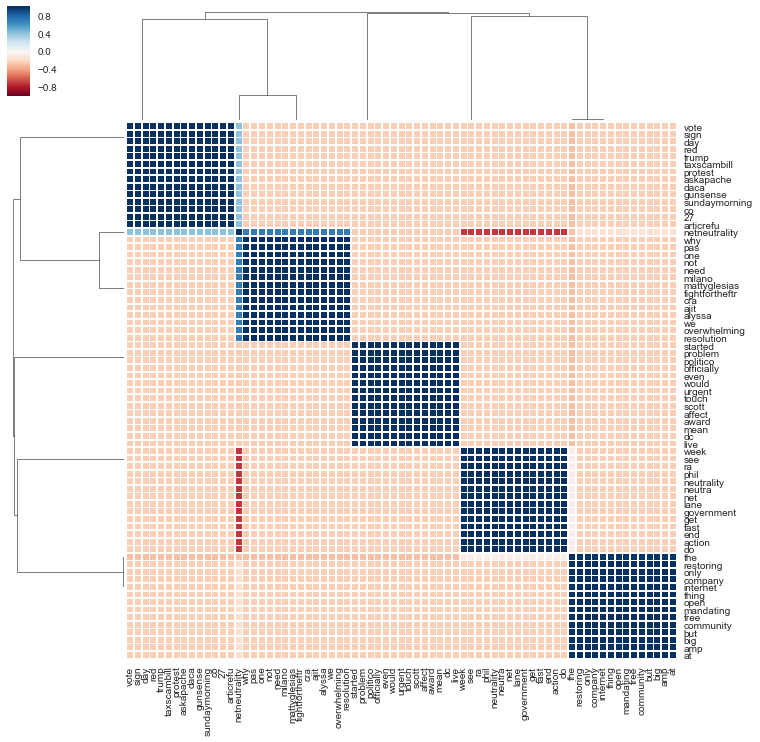

In [135]:
g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

Showing the top terms from the LDA model topics on a heatmap demonstrates how relatively contained each topic is to itself with little crossover.

#### NMF (Non-negative Matrix Factorization) Model

In [136]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_features = 1000
no_topics = 10
no_top_words = 10

##### NMF model using the 1, 2 ngrams transformed text

In [137]:
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(transformed)

In [138]:
display_topics(nmf, features, no_top_words)

Topic 0:
how would would explain explain repeal we whopper burgerking how watch video whopper watch neutrality we watch how
Topic 1:
forget close months cant lessened last cant forget coverage lessened lessened netneutrality coverage last couple though netneutrality couple months
Topic 2:
nra touch overwhelming americans turns could touch nra could tedlieu just nra ra turns nra just thought thought nra
Topic 3:
nra position mattyglesias why position net mattyglesias why nra position neutrality regulations regulations why nra
Topic 4:
government take jackedyotweets the jackedyotweets neutrality guns away net the government guns take away away government
Topic 5:
executive order signed executive executive signed order mandating mandating order kylegriffin montana democratic service providers
Topic 6:
neutrality net neutrality net fcc thehill state first state first montana montana becomes
Topic 7:
pass we need need resolution netneutrality we senate resolution onemorevote pass need onemo

##### NMF model using the 3, 4 ngrams transformed text

In [186]:
nmf2 = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(transformed2)

In [188]:
display_topics(nmf2, features2, no_top_words)

Topic 0:
neutrality we whopper watch we whopper watch video we whopper watch net neutrality we whopper neutrality we whopper would explain repeal net explain repeal net explain repeal net neutrality whopper watch video repeal net neutrality we
Topic 1:
though netneutrality coverage cant forget close months cant forget though netneutrality coverage lessened lessened last couple months lessened last couple couple months cant couple months cant forget coverage lessened last coverage lessened last couple
Topic 2:
touch overwhelming majority americans touch overwhelming majority could touch overwhelming could touch overwhelming majority overwhelming majority americans turns nra could touch overwhelming majority americans turns nra could touch thought nra could thought nra could touch
Topic 3:
why nra position why nra position net mattyglesias why nra position mattyglesias why nra position net neutrality regulations nra position net neutrality nra position net position net neutrality net neu

These two topic modeling algorithms produce somewhat different topic clusters.  The NMF topics seem easier to classify: Topic 0 relates to the Burger King commercial, Topic 1 to decreased coverage, Topics 2 and 3 to the NRA, Topic 4 to the government taking away rights, and so on.  The LDA model does not seem to define the topics as cleanly.

##### NMF Topic Modeling of Twitter User Descriptions

In [218]:
nmf3 = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(transformed3)

In [219]:
display_topics(nmf3, features3, no_top_words)

Topic 0:
click listen fresh electronic listen tunein music 24x7 24x7 click tunein electronic music 24x7 click electronic
Topic 1:
net neutrality neutrality net save net support net bandwidthboys supported supremekame supremekame bandwidthboys supremekame dbfalco
Topic 2:
long trumps trumps office shows long counter shows the counter counter trumps office shows long
Topic 3:
concerned citizen concerned citizen citizen world world mom fan concerned citizen retweeting educator disney always educator
Topic 4:
we truth we stand us stand change seek chooselovetoday truth saves united belief chooselovetoday change
Topic 5:
cencership officialalekpierce gmail cencership officialalekpierce oppose cencership officialalekpierce internet oppose illustrator supporter supporter open freelance illustrator open free
Topic 6:
resist theresistance fbr resist fbr resistance notmypresident bluewave theresistance resist resist theresistance 2018
Topic 7:
geek stuff comics science stuff politics books comic

Topic modeling of the user descriptions seems to produce some idea of topic clusters: music fans, users focused on net neutrality, ones that mention Trump, concerned citizens, etc.

<a id='section5'></a>

### Sentiment Analysis

Sentiment analysis was performed using the TextBlob pattern analyzer.  Textblob is an API that utilizes NLTK and pattern for processing textual data.

In [139]:
def get_tweet_sentiment(tweet):
    return TextBlob(tweet).sentiment.polarity

In [140]:
df['sentiment'] = df.cleaned_text.apply(lambda x: get_tweet_sentiment(' '.join(x)))

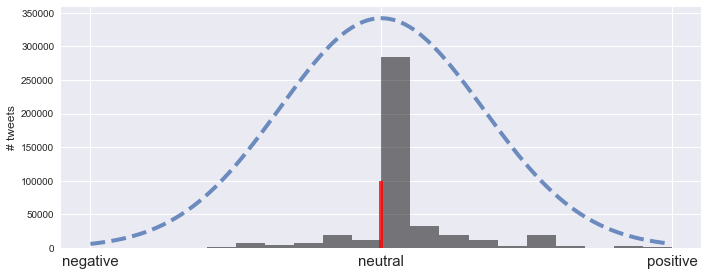

In [163]:
from scipy.stats import norm
hist, edges = np.histogram(df.sentiment.values, bins=np.arange(-1, 1, 0.1))
fig, ax = pl.subplots(figsize=(10,4))
df.sentiment.hist(ax=ax, bins=20, color='k', alpha=0.5)
ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['negative', 'neutral', 'positive'], fontsize=15)
ax.set_ylabel('# tweets', fontsize=12)
x = np.arange(-1, 1, 0.01)
ax.plot(x, norm.pdf(x, 0, 0.35) * 300000, '--', linewidth=4, alpha=0.8)
ax.vlines(0, 0, 100000, color='r', linewidth=4, linestyle='-', alpha=0.8)
pl.tight_layout()
pl.show()

#### Most Negative Tweets

In [162]:
for t in df[df.sentiment == df.sentiment.min()].text[:10]:
    print(t + '\n')

RT @RepSeanMaloney: #BREAKING: The @FCC has announced they’ll officially kill #NetNeutrality in April. I’m a proud cosponsor of legislation…

RT @IndivisibleTeam: 👇Great thread on #NetNeutrality from @jiggy_ca👇 https://t.co/C02RL1RD0e

For the MASSES of non-tech folks... such a great explanation of what #NetNeutrality is and how it works. Folks get… https://t.co/ji3MYUdSFP

RT @tedlieu: Just when you thought @NRA could not be more out of touch with the overwhelming majority of Americans, it turns out the NRA ra…

Excellent piece to supplement your reading on the potential consequences of messing with #NetNeutrality from… https://t.co/yhyBcleR3A

RT @tedlieu: Just when you thought @NRA could not be more out of touch with the overwhelming majority of Americans, it turns out the NRA ra…

RT @tedlieu: Just when you thought @NRA could not be more out of touch with the overwhelming majority of Americans, it turns out the NRA ra…

RT @tedlieu: Just when you thought @NRA could not be more out 

#### Most Positive Tweets

In [143]:
for t in df[df.sentiment == df.sentiment.max()].text[:10]:
    print(t + '\n')

@coindesk Perfect time to #buy!

#BTC #LTC #ETH #ETC #XMR #ZEC #DOGE #DASHPAY #DASH #NEM #VTC #TailsOS… https://t.co/eH7cTQ4hSs

Excellent modification of the #Gadsen flag to serve the point. Also great example of how #StatesRights goes both wa… https://t.co/NFFwWjhsNd

RT @fightfortheftr: We can still stop the FCC from killing #NetNeutrality, and we need just #OneMoreVote to win in the Senate. Join the onl…

RT @EFF: We're extremely proud of the seventh graders who testified in front of Oregon's legislature this week to promote #NetNeutrality, t…

RT @OpenMediaOrg: We can still stop the FCC from killing #NetNeutrality, and we need just #OneMoreVote to win in the Senate. Join the onlin…

RT @EFF: We're extremely proud of the seventh graders who testified in front of Oregon's legislature this week to promote #NetNeutrality, t…

Says the spider to the fly. . . .

#caveatemptor growth by extraction. . . . 

If it is free, you are the product.… https://t.co/pWW0D9huo7

RT @tedlieu: Just wh

##### In this dataset, the sentiment seems to be strongly in favor of preservation of net neutrality and negative toward the FCC and the repeal.  The most positive sentiment tweets are focused on actions to block the repeal, as well as the inherent positive feeling towards net neutrality, and the most negative sentiment tweets are against the repeal and NRA and politicians supporting it.

#### Do the sentiment results differ by state?

In [164]:
df2 = df[['sentiment', 'state']]
df3 = df2.pivot_table(index='state', aggfunc='mean')
df3 = df3.drop(['', 'Burger King', 'IHOP', 'United States', 'Yogurtland'])
pd.set_option("display.max_rows", 500)
df3

,sentiment
state,
Alabama,0.062900
Alaska,0.043706
Arizona,0.012821
Arkansas,0.004261
California,0.059467
Colorado,0.013644
Connecticut,0.055880
Delaware,0.007723
District of Columbia,0.075344


#### How does sentiment by state compare with the current Senate votes by state for or against net neutrality?

Each US state has 2 Senators - a state with 2 Senators that will vote for continued net neutrality scores a sentiment of 1, a state with a split vote gets 0 (neutral) and a state with 2 votes to support the repeal gets a sentiment of -1.

In [145]:
Senate = pd.read_csv('~/Desktop/Senate.csv', index_col='state')

In [146]:
df5 = pd.concat([df3, Senate], axis=1, join='inner')
df5.columns = ['tweet_sentiment', 'Senate_sentiment']

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning:

pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead



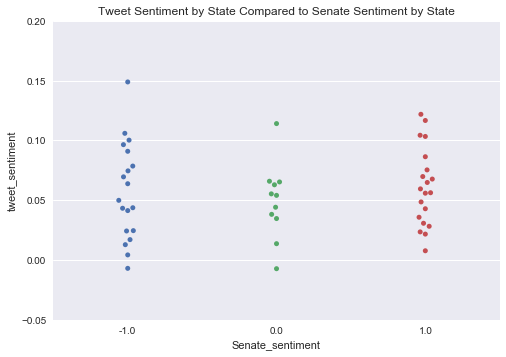

In [205]:
sns.swarmplot(x='Senate_sentiment', y="tweet_sentiment", data=df5)
plt.title('Tweet Sentiment by State Compared to Senate Sentiment by State')
plt.ylim(-0.05, 0.2)
plt.show()

The Senate vote is split primarily along political party lines, despite the fact that most states seem to have a positive sentiment towards net neutrality.  